# Title I Allocations w/ DP ACS

In [1]:
from dp_policy.api import titlei_funding as funding
from dp_policy.titlei.allocators import AbowdAllocator, SonnenbergAuthorizer
from dp_policy.titlei.utils import weighting
from dp_policy.titlei.mechanisms import Laplace, Gaussian, GroundTruth
from dp_policy.titlei.utils import get_saipe
from dp_policy.titlei.utils import get_sppe
from dp_policy.api import titlei_data as data

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.notebook import tqdm
import pandas as pd
import pickle

saipe = get_saipe("../data/saipe19.xls")

%load_ext autoreload
%autoreload 2

## Allocation Algorithm

### Data
Need state per-pupil expenditure (SPPE) from the NCES. Most recent I can find in <5min is the [FY '18 data](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2020308).

Had to use an online tool to convert Table 2 of [this report](https://nces.ed.gov/pubs2020/2020308.pdf).

In [80]:
sppe = get_sppe("../data/sppe18.xlsx")
sppe.head()

,state,ppe,abbrv
0,Alabama,9697,AL
1,Alaska,17726,AK
2,American Samoa,NaN,AS
3,Arizona,8296,AZ
4,Arkansas,10072,AR


Also need a dict matching district IDs to district names to states. Simplest to use [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) ground-truth.

Also, a method for roughly estimating standard errors for the SAIPE estimates, based on [these published docs](https://www.census.gov/programs-surveys/saipe/guidance/district-estimates.html). This could be improved - but start with this as a shortcut.

In [81]:
saipe = get_saipe("../data/saipe19.xls")
saipe.head()

State Postal Code  \
State FIPS Code District ID                     
1               190                        AL   
                5                          AL   
                30                         AL   
                60                         AL   
                90                         AL   

                                                            Name  \
State FIPS Code District ID                                        
1               190               Alabaster City School District   
                5               Albertville City School District   
                30           Alexander City City School District   
                60                Andalusia City School District   
                90                 Anniston City School District   

                             Estimated Total Population  \
State FIPS Code District ID                               
1               190                               34669   
                5                                 22051   
                30                                16920   
                60                                 8842   
                90                                22043   

                             Estimated Population 5-17  \
State FIPS Code District ID                              
1               190                               6710   
                5                                 4131   
                30                                2575   
                60                                1465   
                90                                3065   

                             Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder  \
State FIPS Code District ID                                                                                                          
1               190                                                        649                                                       
                5                                                          957                                                       
                30                                                         703                                                       
                60                                                         406                                                       
                90                                                        1057                                                       

                               cv  
State FIPS Code District ID        
1               190          0.23  
                5            0.23  
                30           0.28  
                60           0.35  
                90           0.23

In [82]:
# average school district student pop
saipe["Estimated Population 5-17"].mean()
saipe["Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder"].mean()

645.2559921116505

### Code

Next, a class for the different ways we might allocate funds based on the poverty estimates (e.g. Abowd's shortcut method vs. the full Sonnenberg method).

Finally, the main method for computing estimates, then grant amounts.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136021116192.56747 authorized reducedto 15999020221.602928 allocated.


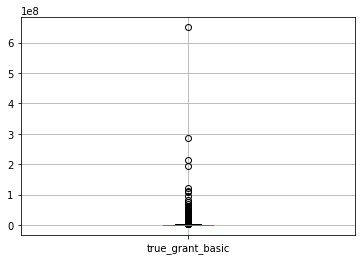

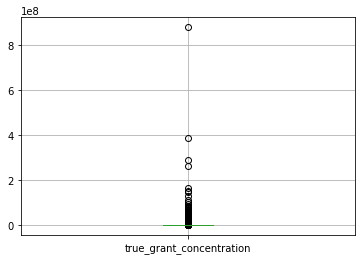

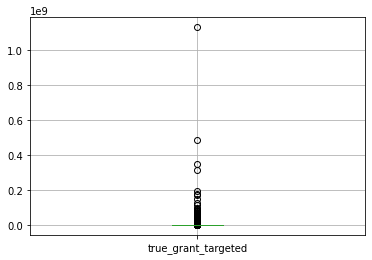

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from dp_policy.api import titlei_funding as funding

# Test with ground truth mechanism
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"))
grants.boxplot('true_grant_basic')
plt.show()
grants.boxplot('true_grant_concentration')
plt.show()
grants.boxplot('true_grant_targeted')
plt.show()

## Hold harmless provision - optional

In [4]:
saipe = get_saipe("../data/saipe19.xls")
grants = funding(SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"))
grants_hold = funding(SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx"), allocator_kwargs={'hold_harmless': True})

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
Holding harmless


ValueError: invalid literal for int() with base 10: 'EA ID'

## Laplace
### Data
From [SAIPE 2019](https://www2.census.gov/programs-surveys/saipe/datasets/2019/2019-school-districts/) release.

### Mechanism

In [5]:
from dp_policy.titlei.mechanisms import Laplace
        
Laplace(saipe, 0.1, 0).poverty_estimates()

(State FIPS Code  District ID
 1                190              34634.0
                  5                22001.0
                  30               16913.0
                  60                8814.0
                  90               22166.0
                                   ...    
 56               6240              7169.0
                  5820               651.0
                  4830              5504.0
                  6090              1468.0
 72               30             3193699.0
 Name: Estimated Total Population, Length: 13184, dtype: float64,
 State FIPS Code  District ID
 1                190              6676.0
                  5                4143.0
                  30               2610.0
                  60               1434.0
                  90               3073.0
                                   ...   
 56               6240             1310.0
                  5820              112.0
                  4830              790.0
                  6090 

### Results
First, using the full Sonnenberg authorization algo.

In [10]:
import itertools
from dp_policy.titlei.allocators import Allocator

def test_params(saipe, mech, eps=list(np.logspace(-3, 1)) + [2.5], delta=[0.0], trials = 1):
    allocations = []
    print(f"{len(eps)*len(delta)*trials} iters:")
    for trial in tqdm(range(trials), desc='trial'):
        for d in tqdm(delta, desc='delta', leave=False):
            for e in tqdm(eps, desc='eps', leave=False):
                allocations.append(funding(
                    SonnenbergAuthorizer,
                    saipe,  
                    mech(saipe, e, d), 
                    get_sppe("../data/sppe18.xlsx"), 
                    verbose=False,
                    uncertainty=False
                ))
    return pd.concat(
        allocations, axis=0,
        keys=itertools.product(range(trials), delta, eps), 
        names=["trial", "delta", "epsilon"] + list(allocations[-1].index.names)
    )

calc_total = SonnenbergAuthorizer.calc_total

def plot_results(results, delta=False):
    results = calc_total(results)
    
    eps, allocations = list(zip(*results.groupby("epsilon")))
    
    mse = []
    
    for e, alloc in results.groupby("epsilon"):
        for grant_type in ("basic", "concentration", "targeted", "total"):
            error = alloc[f"true_grant_{grant_type}"] - alloc[f"est_grant_{grant_type}"]
            error_prop = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])\
                - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
            if (e == 2.5) or (e > 0.1 and e < 0.11):
                print(f"## {grant_type} grants ##")
                print(f"RMSE at eps={e}:", np.sqrt(np.mean(error**2)))
                print(f"RMSE prop eps={e}:", sum(abs(error_prop)))
                print(f"Total misalloc at eps={e}:", sum(abs(error)))
                print("Total true alloc:", sum(alloc[f"true_grant_{grant_type}"]))
        
            if grant_type == "total":
                mse.append(np.sqrt(sum(error**2)/alloc.shape[0]))
    
    grant_type = "total"
    plt.plot(eps, mse)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.xlabel("Epsilon")
    plt.ylabel(f"{grant_type} grant RMSE, nationally")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc = alloc.sort_values(f"true_grant_{grant_type}")
        ids = alloc.index.get_level_values("id").astype('str')
        plt.scatter(ids, alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]), s=2, alpha=0.3, label=f"eps={e}")
    plt.scatter(ids, alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), s=2, alpha=0.3, label="true")
    ax = plt.gca()
    ax.legend()
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Allocation as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

    for i in [0, 25, -2]:
        e = eps[i]
        alloc = allocations[i][allocations[i]["State Postal Code"] == "MI"]
        alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6
        plt.scatter(alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]), alloc.err_prop, s=3, alpha=0.4, label=f"eps={e}")
    ax = plt.gca()
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel("True allocation as % of total")
    plt.ylabel("Misallocation per million as % of total")
    plt.title(f"{grant_type} grants for Michigan")
    plt.show()

test_params(saipe, Laplace, eps=[0.1, 1.0], delta=[0.0], trials=2)

4 iters:


trial:   0%|          | 0/2 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/2 [00:00<?, ?it/s]

delta:   0%|          | 0/1 [00:00<?, ?it/s]

eps:   0%|          | 0/2 [00:00<?, ?it/s]

State Postal Code  \
trial delta epsilon State FIPS Code District ID                     
0     0.0   0.1     1               190                        AL   
                                    5                          AL   
                                    30                         AL   
                                    60                         AL   
                                    90                         AL   
...                                                           ...   
1     0.0   1.0     56              4260                       WY   
                                    6240                       WY   
                                    5820                       WY   
                                    4830                       WY   
                                    6090                       WY   

                                                                                Name  \
trial delta epsilon State FIPS Code District ID                                        
0     0.0   0.1     1               190               Alabaster City School District   
                                    5               Albertville City School District   
                                    30           Alexander City City School District   
                                    60                Andalusia City School District   
                                    90                 Anniston City School District   
...                                                                              ...   
1     0.0   1.0     56              4260              Uinta County School District 6   
                                    6240           Washakie County School District 1   
                                    5820           Washakie County School District 2   
                                    4830             Weston County School District 1   
                                    6090             Weston County School District 7   

                                                 true_pop_total  \
trial delta epsilon State FIPS Code District ID                   
0     0.0   0.1     1               190                   34669   
                                    5                     22051   
                                    30                    16920   
                                    60                     8842   
                                    90                    22043   
...                                                         ...   
1     0.0   1.0     56              4260                   3110   
                                    6240                   7135   
                                    5820                    670   
                                    4830                   5465   
                                    6090                   1462   

                                                 true_children_total  \
trial delta epsilon State FIPS Code District ID                        
0     0.0   0.1     1               190                         6710   
                                    5                           4131   
                                    30                          2575   
                                    60                          1465   
                                    90                          3065   
...                                                              ...   
1     0.0   1.0     56              4260                         736   
                                    6240                        1295   
                                    5820                          90   
                                    4830                         816   
                                    6090                         249   

                                                 true_children_poverty    cv  \
trial delta epsilon State FIPS Code District ID                                
0     0.0   0.1     1               

In [12]:
results = test_params(saipe, Laplace, eps=[0.1, 1.0, 5.0, 10.0, 20.0])
results.to_csv("../results/titlei_laplace.csv")

5 iters:
0 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
137353887581.83426 authorized reduced to 15999020221.602928 allocated.
1 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
136033367506.55687 authorized reduced to 15999020221.602928 allocated.
2 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
136026853101.34161 authorized reduced to 15999020221.602928 allocated.
3 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
136016990563.16171 authorized reduced to 15999020221.602928 allocated.
4 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
136020486370.05583 authorized reduced to 15999020221.602928 allocated.


### Sanity check: using Abowd's method

Abowd reported a mean squared SPPE of 20 million from 2014-15 data.

In [39]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 2.52, 0, sensitivity=1.0), get_sppe("../data/sppe18.xlsx"))
print("Mean Sq. SPPE (2018):", np.mean(grants.adj_sppe**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
Mean Sq. SPPE (2018): 26235395.69087739


They also report an RMSE at e=2.52 of 2509 (again, using 2014-15 Common Core data, which I can't replicate) and 1334 at e=4.74 and 63000 at e=0.1. 

In [40]:
# RMSE
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

3024.604347480388

In [41]:
print("Total misalloc at eps=2.52:", sum(abs(error)))

Total misalloc at eps=2.52: 20301830.401031844


In [42]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 4.74, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


3195.202232429526

In [43]:
grants = funding(AbowdAllocator, saipe, Laplace(saipe, 0.1, 0), get_sppe("../data/sppe18.xlsx"))
error = grants.true_grant_total - grants.est_grant_total
np.sqrt(np.mean(error**2))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


137277.37335131285

So we get some small differences due to inflation or due to other differences in data, but roughly the same values. Biggest difference is in SPPE - apparenlty spending has increased since 2014.

## Gaussian (Advanced Composition, Approx. DP)

Add Gaussian noise ln(1/delta)/epsilon for better accuracy bound.

In [45]:
from dp_policy.titlei.mechanisms import Gaussian

# with delta = 0
results = test_params(
    saipe,
    Gaussian, 
    delta=list(np.linspace(0.02, 1, endpoint=False, num=10))
)
results.to_csv("../results/titlei_gaussian.csv")

510 iters:
0 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
137112616850.47232 authorized reduced to 15999020221.602928 allocated.
1 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
137212746697.90402 authorized reduced to 15999020221.602928 allocated.
2 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
137291139867.57591 authorized reduced to 15999020221.602928 allocated.
3 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
137144277986.18707 authorized reduced to 15999020221.602928 allocated.
4 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
137131635555.13425 authorized reduced to 15999020221.602928 allocated.
5 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
137160376787.72646 authorized reduced to 15999020221.602928 allocated.
6 136021116192.56747 authorized reduced to 15999020221.602928 allocated.
137257660341.32837 authorized reduced to 15999020221

In [46]:
results = pd.read_csv("../results/titlei_gaussian.csv").set_index(['delta', 'epsilon', 'id'])

0.216


/Users/steed/dp-acs/dp_policy/titlei/allocators.py:421: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["true_grant_total"] = \
/Users/steed/dp-acs/dp_policy/titlei/allocators.py:425: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["est_grant_total"] = \


## basic grants ##
RMSE at eps=0.1098541141987558: 8207.673051904729
RMSE prop eps=0.1098541141987558: 0.004211210390994729
Total misalloc at eps=0.1098541141987558: 67375240.20295052
Total true alloc: 15999020221.602888
## concentration grants ##
RMSE at eps=0.1098541141987558: 53758.85202578049
RMSE prop eps=0.1098541141987558: 0.006185805451287929
Total misalloc at eps=0.1098541141987558: 98966826.50206745
Total true alloc: 15999020221.602951
## targeted grants ##
RMSE at eps=0.1098541141987558: 14078.52356111761
RMSE prop eps=0.1098541141987558: 0.0040654388080576965
Total misalloc at eps=0.1098541141987558: 65043037.6998038
Total true alloc: 15999020221.602936
## total grants ##
RMSE at eps=0.1098541141987558: 58929.04293178849
RMSE prop eps=0.1098541141987558: 0.0047898295551651645
Total misalloc at eps=0.1098541141987558: 229897739.73332307
Total true alloc: 47997060664.80879
## basic grants ##
RMSE at eps=2.5: 3865.377174458589
RMSE prop eps=2.5: 0.0014138464443829689
Total mis

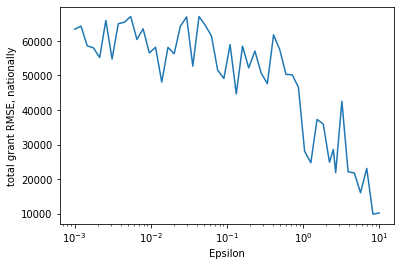

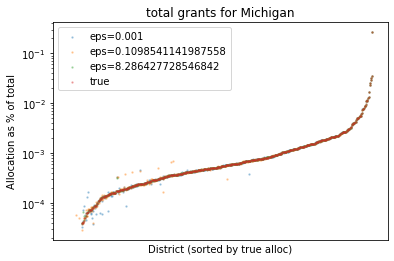

<ipython-input-11-0d755cf381cb>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


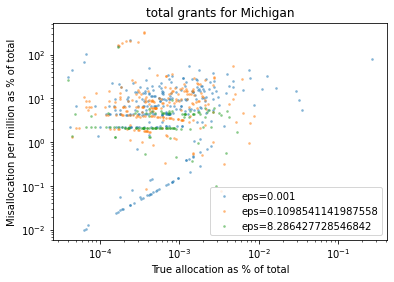

In [47]:
print(results.index.get_level_values('delta').unique()[2])
plot_results(results.xs(results.index.get_level_values('delta').unique()[2], level='delta'))

## basic grants ##
RMSE at eps=0.1098541141987558: 3631.329334984183
RMSE prop eps=0.1098541141987558: 0.0009534596468544317
Total misalloc at eps=0.1098541141987558: 15254420.170429777
Total true alloc: 15999020221.602888
## concentration grants ##
RMSE at eps=0.1098541141987558: 28069.59933374209
RMSE prop eps=0.1098541141987558: 0.001482900523154883
Total misalloc at eps=0.1098541141987558: 23724955.45657249
Total true alloc: 15999020221.602951
## targeted grants ##
RMSE at eps=0.1098541141987558: 4830.229018614638
RMSE prop eps=0.1098541141987558: 0.0008978614609877328
Total misalloc at eps=0.1098541141987558: 14364903.670520416
Total true alloc: 15999020221.602936
## total grants ##
RMSE at eps=0.1098541141987558: 29046.419113373548
RMSE prop eps=0.1098541141987558: 0.001096463531999976
Total misalloc at eps=0.1098541141987558: 52627026.66209782
Total true alloc: 47997060664.80879
## basic grants ##
RMSE at eps=2.5: 2732.019242039542
RMSE prop eps=2.5: 0.0006657514128954149
Total 

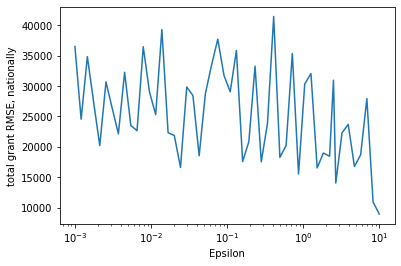

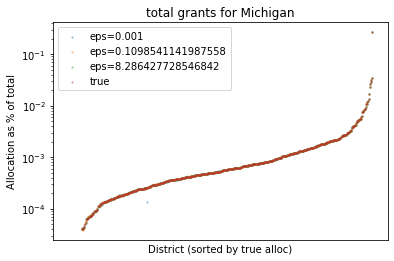

<ipython-input-11-0d755cf381cb>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alloc['err_prop'] = (alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"]) - alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"])) * 1e6


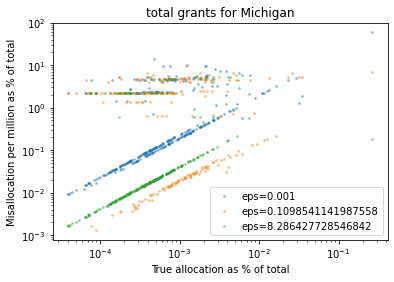

In [48]:
plot_results(results.xs(0.804))

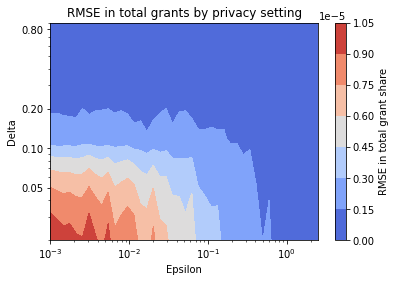

In [51]:
from matplotlib.ticker import FormatStrFormatter

grant_type = 'total'

results = calc_total(results)
eps = list(results.index.get_level_values("epsilon").unique())

delts = list(results.index.get_level_values("delta").unique())
mse = np.zeros((len(eps), len(delts)))
for params, alloc in results.groupby(["epsilon", "delta"]):
    
    e, d = params
    error = alloc[f"true_grant_{grant_type}"]/sum(alloc[f"true_grant_{grant_type}"]) \
        - alloc[f"est_grant_{grant_type}"]/sum(alloc[f"est_grant_{grant_type}"])
    mse[eps.index(e), delts.index(d)] = np.sqrt(sum(error**2)/alloc.shape[0])
    
plt.contourf(eps, delts, mse.transpose(), cmap="coolwarm")
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([0.05, 0.1, 0.2, 0.8])
ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
plt.xlim(None, 2.5)
plt.xlabel("Epsilon")
plt.ylabel("Delta")
plt.title("RMSE in total grants by privacy setting")
plt.colorbar(label="RMSE in total grant share")
plt.show()

# Ground Truth Comparison
How close are our allocation estimates to the actual allocations from 2019? Note that we only have 2020's allocations, when really we need 2021's allocations, which will use the 2019 ACS data (see [here](https://www.nd.gov/dpi/sites/www/files/documents/Educational%20Equity%20%26%20Support/Title%20I/USED%20Census%202019%20Memo.pdf)). But historically the numbers are close.

In [53]:
from dp_policy.titlei.utils import get_allocation_data

true_allocations = get_allocation_data("../data/titlei-allocations_20")
print(true_allocations.columns)
true_allocations["HistAlloc"].sum()

Index(['LEAID', 'District', 'HistAlloc', 'state'], dtype='object')


15999020221.602928

In [55]:
from dp_policy.api import titlei_funding as funding
from dp_policy.titlei.allocators import SonnenbergAuthorizer

allocations = funding(
    SonnenbergAuthorizer, saipe, GroundTruth(saipe), get_sppe("../data/sppe18.xlsx")
)
allocs = allocations[
    ["true_grant_total", "true_grant_basic", "true_grant_concentration", "true_grant_targeted", "true_children_total", "true_children_eligible"]
].join(true_allocations[["HistAlloc", "District"]])
allocs["error"] = allocs.HistAlloc - allocs.true_grant_total
allocs.true_grant_total.sum()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reduced to 15999020221.602928 allocated.
136021116192.56747 authorized reduced to 15999020221.602928 allocated.


15999046700.71252

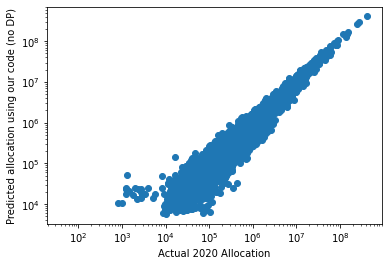

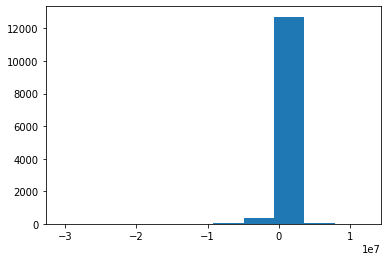

In [57]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.scatter(allocs.HistAlloc, allocs.true_grant_total)
plt.xlabel("Actual 2020 Allocation")
plt.ylabel("Predicted allocation using our code (no DP)")
plt.show()
plt.hist(allocs.error)
plt.show()

Our method seems to be a little heteroskedastic. Variation could be due to 1) approximations in our funding algo; 2) differences in data.

In [58]:
# error per student
allocs["error_per_capita"] = allocs.error / allocs.true_children_total
np.mean(allocs.error_per_capita), np.sqrt(np.mean(allocs.error_per_capita**2))

(20.879231455964167, 148.36257841383988)

In [59]:
allocs.sort_values("error_per_capita").head(10)

,,true_grant_total,true_grant_basic,true_grant_concentration,true_grant_targeted,true_children_total,true_children_eligible,HistAlloc,District,error,error_per_capita
State FIPS Code,District ID,,,,,,,,,,
30,9210,5.259479e+04,46843.071951,6.349072e+04,5.122794e+04,55,25,1308.576975,Drummond High School District,-51286.211907,-932.476580
35,330,2.510612e+05,182321.355553,2.471169e+05,2.938792e+05,166,109,119891.947939,Carrizozo Municipal Schools,-131169.239279,-790.176140
41,3630,8.201031e+04,68626.885861,9.301633e+04,8.515564e+04,74,36,24329.785959,Harney County Union High School District 1J,-57680.528122,-779.466596
35,1,1.175623e+05,93669.687257,1.269591e+05,1.276975e+05,109,56,37999.407212,Vaughn Municipal Schools,-79562.935826,-729.935191
6,19920,4.708628e+04,38146.911424,5.170402e+04,5.039245e+04,31,19,25151.928704,Klamath River Union Elementary School District,-21934.346974,-707.559580
30,13140,2.705267e+04,28105.843171,3.809443e+04,2.155492e+04,39,15,0.000000,Greycliff Elementary School District,-27052.672088,-693.658259
6,37470,3.366669e+05,273051.576512,3.700919e+05,3.599461e+05,295,136,142635.600476,South Fork Union School District,-194031.270623,-657.733121
13,5100,1.278281e+06,996370.877624,1.350473e+06,1.414921e+06,1167,578,533694.657463,Treutlen County School District,-744586.668896,-638.034849
30,19740,2.142242e+04,22484.674536,3.047555e+04,1.679604e+04,34,12,0.000000,Opheim K-12 Schools,-21422.420537,-630.071192


# Uncertainty

## Calculating confidence intervals

The simplest approximate measure of uncertainty is given by the Census's median coefficient of varation in the poverty estimates for each district. We can construct a confidence interval for each allocation as follows, ignoring variance due to missing cutoffs (for now) by using the Abowd method.

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


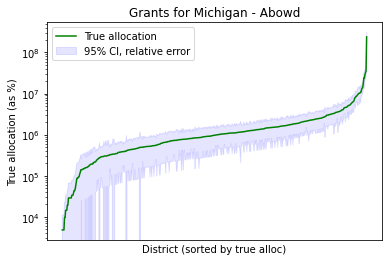

In [35]:
# test with one run of abowd
allocator = AbowdAllocator(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()
estimates = allocator.estimates[allocator.estimates["State Postal Code"] == "MI"].sort_values("true_grant_total")
y = estimates.true_grant_total
x = estimates.index.get_level_values("District ID").astype('str')
ax = plt.gca()

plt.plot(x, y, color='green', label="True allocation")
ax.fill_between(x, estimates.true_ci_lower, estimates.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
ax.axes.xaxis.set_ticks([])
ax.set_yscale('log')
plt.xlabel("District (sorted by true alloc)")
plt.ylabel("True allocation (as %)")
plt.title(f"Grants for Michigan - Abowd")
ax.legend()
plt.show()

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


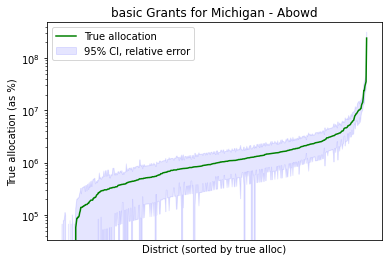

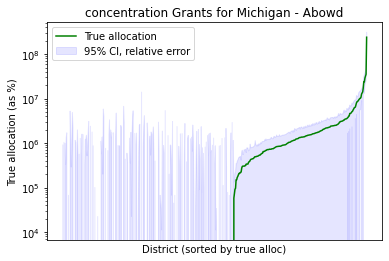

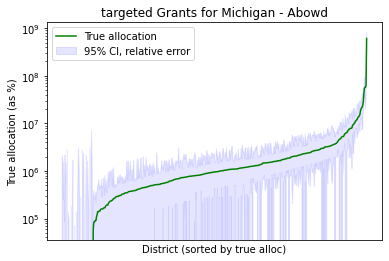

In [36]:
# test with one run of Sonnenberg
allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()

for grant_type in ["basic", "concentration", "targeted"]:
    estimates = allocator.estimates[allocator.estimates["State Postal Code"] == "MI"].sort_values(f"true_grant_{grant_type}")
    y = estimates[f"true_grant_{grant_type}"]
    x = estimates.index.get_level_values("District ID").astype('str')
    ax = plt.gca()

    plt.plot(x, y, color='green', label="True allocation")
    ax.fill_between(x, estimates[f"true_grant_{grant_type}_ci_upper"], estimates[f"true_grant_{grant_type}_ci_lower"], color='b', alpha=0.1, label="95% CI, relative error")
    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"{grant_type} Grants for Michigan - Abowd")
    ax.legend()
    plt.show()

## Measures of "cheating" - districts receiving less than they should, if data were perfect

One method (see notes) is to compute the expected value of $y$ (the expected allocation) given the following assumptions:
1. $\mu$ is normally distributed
2. $\hat{\mu}$ is unbiased
3. $\hat{\nu}$ is unbiased and a point mass

See notes for the expectation math.

An example for basic grants:

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


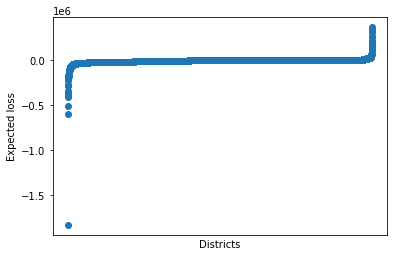

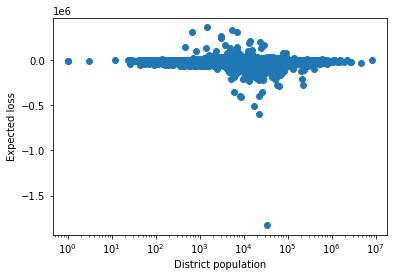

28603.537629958762

In [8]:
allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()

df = allocator.estimates

df = df.sort_values("expected_loss_basic")
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
# ax.set_yscale('log')
plt.scatter(range(len(df)), df["expected_loss_basic"])
plt.xlabel("Districts")
plt.ylabel("Expected loss")
plt.show()

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.scatter(allocator.estimates.true_pop_total, df["expected_loss_basic"])
ax.set_xscale('log')
plt.xlabel("District population")
plt.ylabel("Expected loss")
plt.show()

# RMSE
np.sqrt(np.mean((df.expected_loss_basic)**2))

In [13]:
df["expected_loss_per_child_poverty"] = df.expected_loss_basic / df.true_children_poverty
df.sort_values("expected_loss_per_child_poverty", ascending=True).dropna().tail()

,,State Postal Code,Name,true_pop_total,true_children_total,true_children_poverty,cv,est_pop_total,est_children_total,est_children_poverty,true_children_eligible,...,est_grant_concentration_ci_lower,est_grant_targeted_ci_upper,est_grant_targeted_ci_lower,est_ci_upper,est_ci_lower,prob_el_basic,prob_el_concentration,prob_el_targeted,expected_loss_basic,expected_loss_per_child_poverty
State FIPS Code,District ID,,,,,,,,,,,,,,,,,,,,,
9,30,CT,Andover School District,3259,270,10,0.42,3259.0,271.0,11.0,10,...,0.0,125411.458158,0.0,250822.916317,0.0,0.5,1.908473e-13,0.202328,31266.82822,3126.682822
25,8530,MA,New Salem-Wendell School District,1807,118,10,0.67,1808.0,117.0,9.0,10,...,0.0,132462.042490,0.0,392834.463704,0.0,0.5,1.252257e-01,0.500000,31266.82822,3126.682822
9,870,CT,Colebrook School District,1408,93,10,0.67,1408.0,93.0,10.0,10,...,0.0,175590.734886,0.0,464893.425124,0.0,0.5,2.777454e-01,0.500000,31266.82822,3126.682822
36,15270,NY,Indian Lake Central School District,1234,114,10,0.67,1234.0,115.0,10.0,10,...,0.0,162466.052119,0.0,451768.742357,0.0,0.5,1.446402e-01,0.500000,31266.82822,3126.682822
34,6600,NJ,Hampton Borough School District,1343,117,10,0.67,1343.0,117.0,10.0,10,...,0.0,157776.027886,0.0,447078.718124,0.0,0.5,1.298996e-01,0.500000,31266.82822,3126.682822


Another method is just to try to compute the probability of eligibility. This might tell us if some districts are getting lucky, unlucky in receiving funding.

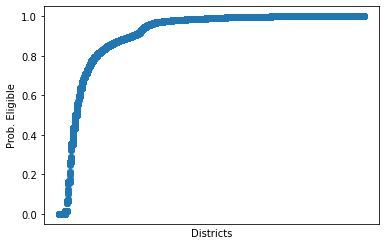

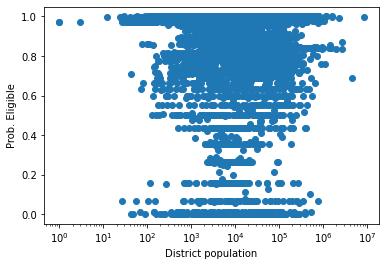

In [15]:
df = df.sort_values("prob_el_basic")
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
# ax.set_yscale('log')
plt.scatter(range(len(df)), df["prob_el_basic"])
plt.xlabel("Districts")
plt.ylabel("Prob. Eligible")
plt.show()

ax = plt.gca()
ax.axes.xaxis.set_ticks([])
plt.scatter(allocator.estimates.true_pop_total, df["prob_el_basic"])
ax.set_xscale('log')
plt.xlabel("District population")
plt.ylabel("Prob. Eligible")
plt.show()

In [17]:
# difference in prob of eligibility vs actual eligibility
# df["eligible_basic"] = df.true_grant_basic > 0.0
eps = 18

allocator = SonnenbergAuthorizer(
    data(saipe, Laplace(saipe, eps, 0.5), get_sppe("../data/sppe18.xlsx"))
)
allocator.calc_auth()
allocator.calc_uncertainty()

df = allocator.estimates

# calc prop. of districts with prob > k who were ineligible
ks = np.linspace(0, 1)
k_eligible_true = [((df.prob_el_basic > k) & ~df.true_eligible_basic).sum() for k in ks]

trials = []
hist = []
n = 100
for trial in tqdm(range(n)):
    allocatort = SonnenbergAuthorizer(
        data(saipe, Laplace(saipe, eps, 0), get_sppe("../data/sppe18.xlsx"))
    )
    allocatort.calc_auth()
    allocatort.calc_uncertainty()
    trial = allocatort.estimates
    trials.append(trial)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


  0%|          | 0/100 [00:00<?, ?it/s]

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dro

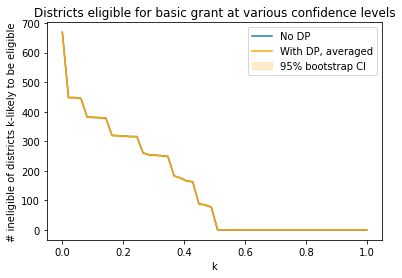

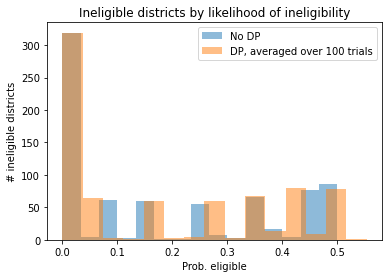

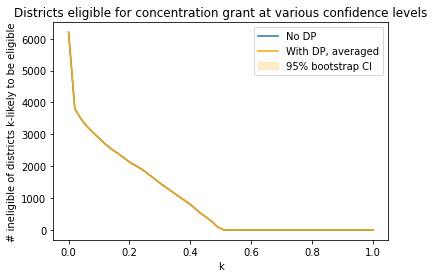

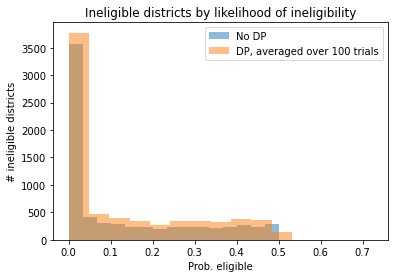

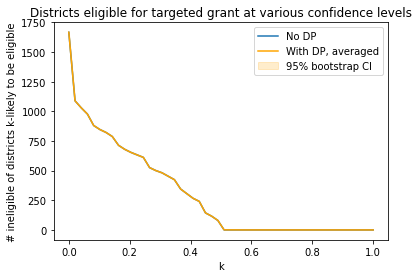

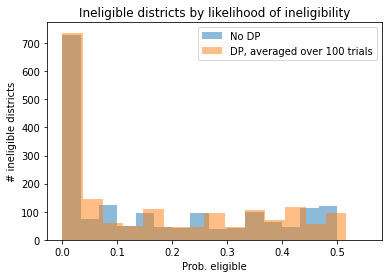

In [21]:
alpha = 0.01

for grant_type in ["basic", "concentration", "targeted"]:
    k_eligible_est = [
        [((trial[f"prob_el_{grant_type}"] > k) & ~trial[f"est_eligible_{grant_type}"]).sum() for k in ks]
        for trial in trials
    ]
    upper = np.percentile(np.array(k_eligible_est), 1-alpha/2, axis=0)
    lower = np.percentile(np.array(k_eligible_est), alpha/2, axis=0)
    mean = np.mean(np.array(k_eligible_est), axis=0)

    k_eligible_true = [((df[f"prob_el_{grant_type}"] > k) & ~df[f"true_eligible_{grant_type}"]).sum() for k in ks]
    
    plt.plot(ks, k_eligible_true, label="No DP")
    plt.plot(ks, mean, color='orange', label="With DP, averaged")
    plt.fill_between(ks, lower, upper, color='orange', alpha=0.2, label="95% bootstrap CI")
    plt.legend()
    plt.ylabel("# ineligible of districts k-likely to be eligible")
    plt.xlabel("k")
    plt.title(f"Districts eligible for {grant_type} grant at various confidence levels")
    plt.show()


    # histogram
    plt.hist(df[f"prob_el_{grant_type}"][~df[f"true_eligible_{grant_type}"]], bins=15, label="No DP", alpha=0.5)
    hist = [k for k in trial[f"prob_el_{grant_type}"][~trial[f"est_eligible_{grant_type}"]] for trial in trials]
    plt.hist(hist, bins=15, weights=1/n*np.ones(len(hist)), label=f"DP, averaged over {n} trials", alpha=0.5)
    plt.title("Ineligible districts by likelihood of ineligibility")
    plt.xlabel("Prob. eligible")
    plt.ylabel("# ineligible districts")
    plt.legend()
    plt.show()

what kinds of districts are in the 1% of "cheated" districts? let's look at k=0.5

## Results

In [151]:
from dp_policy.api import titlei_funding

# 100 trials of DP
trials_laplace = []
trials_gaussian = []
for i in range(100):
    trials_laplace.append(funding(SonnenbergAuthorizer, saipe, Laplace(saipe, 17, 0), get_sppe("../data/sppe18.xlsx")))
    trials_gaussian.append(funding(SonnenbergAuthorizer, saipe, Gaussian(saipe, 17, 0.8), get_sppe("../data/sppe18.xlsx")))

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136021636582.98068 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136015183589.83414 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136018847725.84697 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136026553165.37878 authorized reducedto 15999020221.602928 allocated.
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
136021116192.56747 authorized reducedto 15999020221.602928 allocated.
136019298134.1442 authorized reducedto 1

In [152]:
import pickle

pickle.dump(trials_gaussian, open('../results/uncertainty_gaussian_sonnenberg.pkl', 'wb'))
pickle.dump(trials_laplace, open('../results/uncertainty_laplace_sonnenberg.pkl', 'wb'))

In [153]:
import pickle

trials_gaussian = pickle.load( open('../results/uncertainty_gaussian_sonnenberg.pkl', 'rb'))
trials_laplace = pickle.load( open('../results/uncertainty_laplace_sonnenberg.pkl', 'rb'))

[462824020.94161385, 462840299.6673689, 462841737.3173904, 462822855.2437982, 462816482.44983107, 462830999.04026777, 462845746.35956573, 462802600.8257093, 462806049.94182587, 462842226.00936466, 462812324.09494454, 462825477.404486, 462818210.5735216, 462824561.7874051, 462840306.5160426, 462817604.17654556, 462819730.95393896, 462818687.6475747, 462830350.0292324, 462827909.09678173, 462805224.07426506, 462871940.04184407, 462822816.4434567, 462810964.1891345, 462823862.1024415, 462804846.64482874, 462810856.5915192, 462838668.29985064, 462842426.3687169, 462893275.97106534, 462852557.9261036, 462846578.9573317, 462825218.91440845, 462770666.3817068, 462822191.5956028, 462825361.3744827, 462890905.44549876, 462828829.3798849, 462844642.1573651, 462831280.6207208, 462809818.0116389, 462876629.0044988, 462834396.03578705, 462815231.08159953, 462829029.02726537, 462820261.23617554, 462831572.09701484, 462802679.17332053, 462818791.49010426, 462839147.35206664, 462839853.49715096, 46279

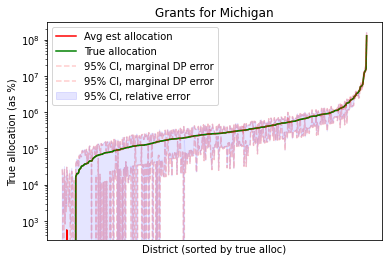

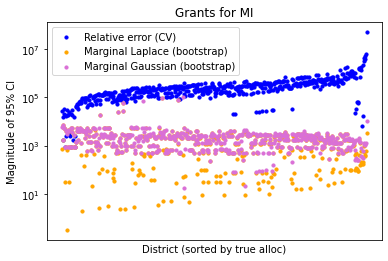

In [157]:
import scipy.stats as stats

def plot_uncertainty(grants, grants_other=None, state="MI", alpha=0.05):
    z = stats.norm.ppf(1-alpha/2)
    
    grants = [
        sample[sample["State Postal Code"] == state].sort_values("true_grant_total")
        for sample in grants
    ]
    baseline = grants[0]
    x = baseline.index.get_level_values("District ID").astype('str')
    y = baseline.true_grant_total
    ax = plt.gca()
    
    print(list(grant.est_grant_total.sum() for grant in grants))
    
    # CI from relative error - 95% of samples differ by at most this much
    ax.fill_between(x, baseline.true_ci_lower, baseline.true_ci_upper, color='b', alpha=0.1, label="95% CI, relative error")
    
    # percentile interval from DP (bootstrapping) - 95% of samples differed by at most this much
    samples_mean = [
        sample.est_grant_total
        for sample in grants
    ]
    samples_upper = [
        sample.est_ci_upper
        for sample in grants
    ]
    samples_lower = [
        sample.est_ci_lower
        for sample in grants
    ]
    # get value for which 95% of samples are above (for lower) or below (for upper)
    mean = np.mean(samples_mean, axis=0)
    ci_lower = np.percentile(samples_lower, alpha/2, axis=0)
    ci_upper = np.percentile(samples_upper, 1-alpha/2, axis=0)

    plt.plot(x, mean, color='r', label="Avg est allocation")
    plt.plot(x, y, color='green', label="True allocation")
    plt.plot(x, ci_lower, 'r--', alpha=0.2, label="95% CI, marginal DP error")
#     ax.fill_between(x, baseline.true_ci_lower, ci_lower, color='r', alpha=0.1, label="95% CI, marginal DP error")
    plt.plot(x, ci_upper, 'r--', alpha=0.2, label="95% CI, marginal DP error")
#     ax.fill_between(x, baseline.true_ci_upper, ci_upper, color='r', alpha=0.1, label="95% CI, marginal DP error")
    

    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("True allocation (as %)")
    plt.title(f"Grants for Michigan")
    ax.legend()
    plt.show()
    
    # plot of interval magnitude
    ax = plt.gca()
    ci = np.abs(baseline.true_ci_upper - baseline.true_ci_lower)
    plt.scatter(x, ci, s=10, color='b', label="Relative error (CV)")
    
    samples = [
        np.abs(sample.est_ci_upper - sample.est_ci_lower)
        for sample in grants
    ]
    plt.scatter(x, ci - np.percentile(samples, 1-alpha/2, axis=0), s=10, color='orange', label="Marginal Laplace (bootstrap)")
    
    if grants_other is not None:
        grants_other = [
            sample[sample["State Postal Code"] == state].sort_values("true_grant_total")
            for sample in grants_other
        ]
        samples_other = [
            np.abs(sample.est_ci_upper - sample.est_ci_lower)
            for sample in grants_other
        ]
        plt.scatter(
            x, 
            ci - np.percentile(samples_other, 1-alpha/2, axis=0),
            s=10, color='orchid', label="Marginal Gaussian (bootstrap)"
        )


    ax.axes.xaxis.set_ticks([])
    ax.set_yscale('log')
    plt.xlabel("District (sorted by true alloc)")
    plt.ylabel("Magnitude of 95% CI")
    plt.title(f"Grants for {state}")
    ax.legend()
    plt.show()

plot_uncertainty(trials_laplace, trials_gaussian)

# Discrimination

## Data
Using 2014-2018 ACS race data by school district from the NCES. See notes for more details.

Data for just the total child population

In [2]:
from dp_policy.titlei.utils import get_acs_data

demographics = get_acs_data(
    "../data/discrimination/CDP05.txt",
    "demo"
)
print(demographics.shape)
social = get_acs_data(
    "../data/discrimination/CDP02.txt",
    "social"
)
print(social.shape)
economic = get_acs_data(
    "../data/discrimination/CDP03.txt",
    "social"
)
print(economic.shape)
housing = get_acs_data(
    "../data/discrimination/CDP04.txt",
    "housing"
)
print(housing.shape)

(11721, 256)
(11720, 340)


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (183,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(11721, 202)


/opt/miniconda3/envs/dp-acs/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (161,162,279,280,283,284,287,288,291,292,295,296,299,300,303,304,307,308,315,316,319,320) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(11721, 494)


In [3]:
acs = demographics.join(social, lsuffix="_demo", rsuffix="_social", how="inner")\
    .join(economic, rsuffix="_econ", how="inner")\
    .join(housing, rsuffix="_housing", how="inner")
print(acs.shape)
print(acs[acs['Total population (RACE) - est'].isna()].shape)
print(list(c for c in acs.columns if "est" in c or "pct" in c))

(11720, 1292)
(0, 1292)
['Total population (SEX AND AGE) - est', 'Male (SEX AND AGE) - est', 'Male (SEX AND AGE) - pct', 'Male (SEX AND AGE) - pctmoe', 'Under 5 years (SEX AND AGE) - est', 'Under 5 years (SEX AND AGE) - pct', 'Under 5 years (SEX AND AGE) - pctmoe', '5 to 9 years (SEX AND AGE) - est', '5 to 9 years (SEX AND AGE) - pct', '5 to 9 years (SEX AND AGE) - pctmoe', '10 to 14 years (SEX AND AGE) - est', '10 to 14 years (SEX AND AGE) - pct', '10 to 14 years (SEX AND AGE) - pctmoe', '15 to 17 years (SEX AND AGE) - est', '15 to 17 years (SEX AND AGE) - pct', '15 to 17 years (SEX AND AGE) - pctmoe', '18 and 19 years (SEX AND AGE) - est', '18 and 19 years (SEX AND AGE) - pct', '18 and 19 years (SEX AND AGE) - pctmoe', 'Female (SEX AND AGE) - est', 'Female (SEX AND AGE) - pct', 'Female (SEX AND AGE) - pctmoe', 'Under 5 years (SEX AND AGE) - est', 'Under 5 years (SEX AND AGE) - pct', 'Under 5 years (SEX AND AGE) - pctmoe', '5 to 9 years (SEX AND AGE) - est', '5 to 9 years (SEX AND AGE

In [4]:
saipe = get_saipe("../data/saipe19.xls")
# saipe = saipe.join(acs, how="inner")

In [7]:
from dp_policy.titlei.mechanisms import Gaussian

# run 100 trials for a signle eps, delta combo
results = test_params(
    saipe,
    Gaussian, 
    eps=[0.1],
    delta=[0.1],
    trials=50
)
pickle.dump(results, open('../results/discrimination.pkl', 'wb'))

NameError: name 'test_params' is not defined

## Full dataset

In [6]:
results = pickle.load(open('../results/discrimination.pkl', 'rb'))
print(results.shape)
variables = [
    'Total population (RACE) - est',
]
# add race variables
variables += [
    r for r in acs.columns 
    if r.endswith("(RACE) - pct") and "and" not in r and "races" not in r and not r.startswith("One race")
]
# add income variables
variables += [
    r for r in acs.columns 
    if r.startswith("Median household income (dollars) (")
]
# add rural/urban - need a 3rd data source
# add immigrant status
variables += [
    "Foreign born (PLACE OF BIRTH) - est",
    "Foreign born (PLACE OF BIRTH) - pct",
    "Not a U.S. citizen (U.S. CITIZENSHIP STATUS) - est",
    "Not a U.S. citizen (U.S. CITIZENSHIP STATUS) - pct"
]
# add language isolation
variables += [
    'Language other than English (LANGUAGE SPOKEN AT HOME) - est',
    'Language other than English (LANGUAGE SPOKEN AT HOME) - pct'
]
# add renters vs. homeowners (housing security)
variables += [
    'Renter-occupied (HOUSING TENURE) - est',
    'Renter-occupied (HOUSING TENURE) - pct',
    'Average household size of renter-occupied unit (HOUSING TENURE) - est'
]
print(variables)
grants = results.join(acs[variables], how="inner")
print(grants.shape)
print(grants[grants["Total population (RACE) - est"].isna()].groupby(["State FIPS Code", "District ID"]).groups.keys())
# for regression
grants["error"] =  grants.est_grant_total - grants.true_grant_total
grants.to_csv("../results/discrimination.csv")

(659100, 26)
['Total population (RACE) - est', 'White (RACE) - pct', 'Black or African American (RACE) - pct', 'Cherokee tribal grouping (RACE) - pct', 'Chippewa tribal grouping (RACE) - pct', 'Navajo tribal grouping (RACE) - pct', 'Sioux tribal grouping (RACE) - pct', 'Asian (RACE) - pct', 'Asian Indian (RACE) - pct', 'Chinese (RACE) - pct', 'Filipino (RACE) - pct', 'Japanese (RACE) - pct', 'Korean (RACE) - pct', 'Vietnamese (RACE) - pct', 'Other Asian (RACE) - pct', 'Native Hawaiian (RACE) - pct', 'Guamanian or Chamorro (RACE) - pct', 'Samoan (RACE) - pct', 'Some other race (RACE) - pct', 'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est', 'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - moe', 'Foreign born (PLACE OF BIRTH) - est', 'Foreign born (PLACE OF BIRTH) - pct', 'Not a U.S. citizen (U.S. CITIZENSHIP STATUS) - est', 'Not a U.S. citizen (U.S. CITIZENSHIP STATUS) - pct', 'Language ot

## Random forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

averaged = results.groupby(["State FIPS Code", "District ID"]).mean().join(acs[variables], how="inner")
averaged["misalloc"] = averaged.est_grant_total - averaged.true_grant_total
averaged = averaged.replace('-', np.nan).replace('250,000+', '250000').dropna()
averaged = averaged.fillna(averaged.mean(skipna=True))

In [25]:
from sklearn.tree import plot_tree, DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=4)
features = [
    'Total population (RACE) - est',
    'White (RACE) - pct',
    'Black or African American (RACE) - pct',
#     'Cherokee tribal grouping (RACE) - pct',
#     'Chippewa tribal grouping (RACE) - pct',
#     'Navajo tribal grouping (RACE) - pct',
#     'Sioux tribal grouping (RACE) - pct',
    'Asian (RACE) - pct',
#     'Asian Indian (RACE) - pct',
#     'Chinese (RACE) - pct',
#     'Filipino (RACE) - pct',
#     'Japanese (RACE) - pct',
#     'Korean (RACE) - pct',
#     'Vietnamese (RACE) - pct',
#     'Other Asian (RACE) - pct',
#     'Native Hawaiian (RACE) - pct',
#     'Guamanian or Chamorro (RACE) - pct',
#     'Samoan (RACE) - pct',
#     'Some other race (RACE) - pct',
    'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
    'Foreign born (PLACE OF BIRTH) - pct',
    'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
    'Renter-occupied (HOUSING TENURE) - pct'
]
print(averaged[features].columns)
dt.fit(
    averaged[features],
    averaged.misalloc
)

Index(['Total population (RACE) - est', 'White (RACE) - pct',
       'Black or African American (RACE) - pct', 'Asian (RACE) - pct',
       'Median household income (dollars) (INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)) - est',
       'Foreign born (PLACE OF BIRTH) - pct',
       'Language other than English (LANGUAGE SPOKEN AT HOME) - pct',
       'Renter-occupied (HOUSING TENURE) - pct'],
      dtype='object')


DecisionTreeRegressor(max_depth=4)

In [26]:
importances = dt.feature_importances_
print(dt.n_features_)
importances

8


array([9.60892670e-01, 2.06042894e-02, 0.00000000e+00, 1.82353866e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.67654128e-04])

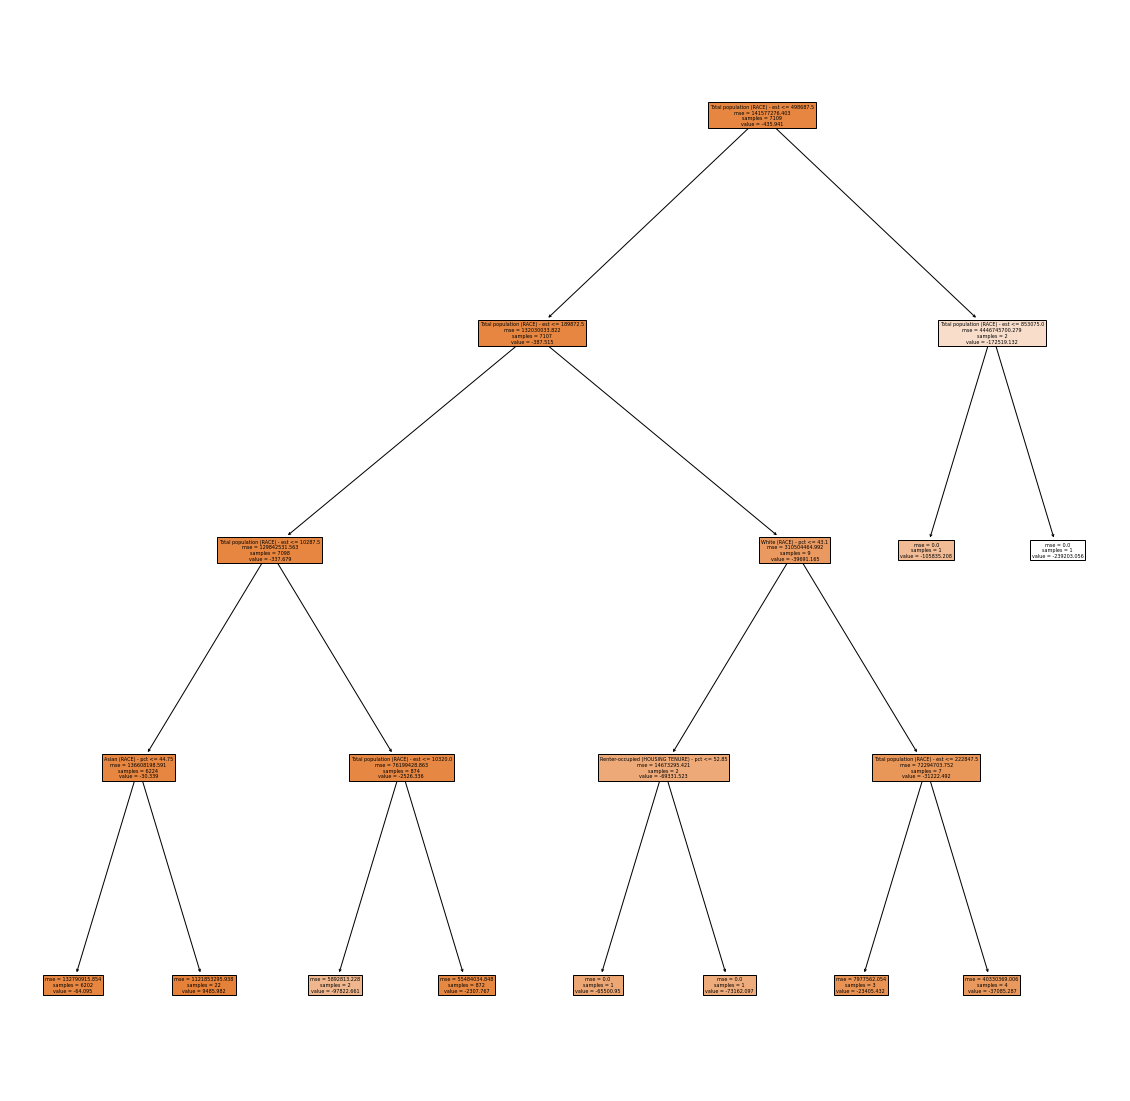

In [27]:
plt.rcParams['figure.figsize'] = [20, 20]
plot_tree(
    dt,
    feature_names = features,
    filled=True
)
plt.show()

## Plot for just (2.52, 0.0)-DP

In [18]:
grants = calc_total(funding(saipe, SonnenbergAuthorizer, Laplace(saipe, 2.52, 0), get_sppe("../data/sppe18.xlsx"), weighting))
grants_gaus = calc_total(funding(saipe, SonnenbergAuthorizer, Gaussian(saipe, 2.52, 0.2), get_sppe("../data/sppe18.xlsx"), weighting))
error = grants.true_grant_total/sum(grants.true_grant_total) - grants.est_grant_total/sum(grants.est_grant_total)
error_gaus = grants_gaus.true_grant_total/sum(grants_gaus.true_grant_total) - grants_gaus.est_grant_total/sum(grants_gaus.est_grant_total)

[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']
[WARN] Dropping districts with missing SPPE data: ['Puerto Rico']


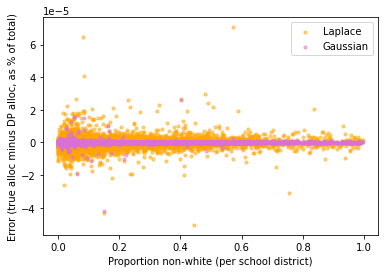

In [241]:
grants['prop_nonwhitealone'] = 1 - grants.race_2est / grants.race_1est
grants.prop_nonwhitealone[saipe.prop_nonwhitealone.isna()] = 0

plt.scatter(grants.prop_nonwhitealone, error, s=10, alpha=0.5, color='orange', label="Laplace")
plt.scatter(grants.prop_nonwhitealone, error_gaus, s=10, alpha=0.5, color='orchid', label="Gaussian")
ax = plt.gca()
ax.legend()
plt.xlabel("Proportion non-white (per school district)")
plt.ylabel("Error (true alloc minus DP alloc, as % of total)")
plt.show()